In [ ]:
#!L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import time
%matplotlib inline

In [ ]:
#!L
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


## 1. KITTI Stereo Depth 2012

http://www.cvlibs.net/datasets/kitti/eval_stereo_flow.php?benchmark=stereo

194 training image pairs, 195 test image pairs with hidden ground truth, ground truth depth captured by lidar.

Zero disparity value means that disparity is unknown.

In [ ]:
import yfile
import os
if not os.path.exists('./kitti_stereo_2012_training_data.zip'):
    yfile.download_from_yadisk("https://disk.yandex.ru/d/WrA28IyHHYENOw",
                               "kitti_stereo_2012_training_data.zip",
                               target_dir='.')

In [ ]:
!unzip -q ./kitti_stereo_2012_training_data.zip

In [ ]:
def normalize_disparity(img):
    img = img.astype(np.float32) / 256
    return img

([], [])

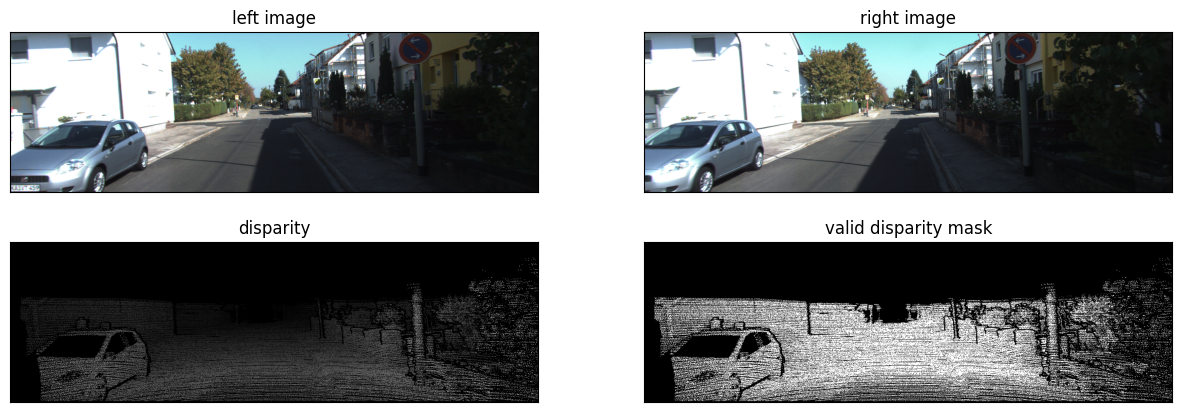

In [ ]:
img_name = "000002_10.png"

plt.figure(figsize=(15,5))

plt.subplot(2,2,1)
plt.title('left image')
plt.imshow(Image.open(f'./kitti_stereo_2012_training_data/train/colored_0/{img_name}'));
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,2)
plt.title('right image')
plt.imshow(Image.open(f'./kitti_stereo_2012_training_data/train/colored_1/{img_name}'));
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
plt.title('disparity')
disp = np.array(Image.open(f'./kitti_stereo_2012_training_data/train/disp_noc/{img_name}'))
plt.imshow(normalize_disparity(disp), 'gray')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,4)
plt.title('valid disparity mask')
plt.imshow(disp > 0, 'gray')
plt.xticks([])
plt.yticks([])

In [ ]:
sample_max_disparity = normalize_disparity(disp).max()
sample_shape = disp.shape

print(f'max disp = {sample_max_disparity} , disp shape {sample_shape}')

max disp = 145.90625 , disp shape (376, 1241)


## 2. Dataset loading

In [ ]:
from kitti_dataset import KITTIStereoRAM

In [ ]:
KITTIStereoRAM??

In [ ]:
means = np.array([0.35715697, 0.37349922, 0.35886646] , dtype=np.float32)
stds = np.array([0.27408948, 0.2807328,  0.27994434], dtype=np.float32)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.Normalize(means, stds),
])

# min kitti shape is [370, 1226], max shape is [376, 1242]
PAD_HEIGHT = 128*3
PAD_WIDTH = 1280
CROP_WIDTH = 768
def transforms_train(left_image, right_image, disparity, valid_pixels_mask):
    disparity = torchvision.transforms.functional.to_tensor(disparity)
    valid_pixels_mask = torchvision.transforms.functional.to_tensor(valid_pixels_mask)
    left_image = transform_train(left_image)
    right_image = transform_train(right_image)
    left_image = pad_to_size(left_image, PAD_HEIGHT, PAD_WIDTH)
    right_image = pad_to_size(right_image, PAD_HEIGHT, PAD_WIDTH)
    disparity = pad_to_size(disparity, PAD_HEIGHT, PAD_WIDTH)
    valid_pixels_mask = pad_to_size(valid_pixels_mask, PAD_HEIGHT, PAD_WIDTH)

    shift = torch.randint(0, PAD_WIDTH-CROP_WIDTH, (1,))
    left_image = left_image[:,:,shift:shift+CROP_WIDTH]
    right_image = right_image[:, :, shift: shift+CROP_WIDTH]
    disparity = disparity[:, :, shift: shift+ CROP_WIDTH]
    valid_pixels_mask = valid_pixels_mask[:, :, shift: shift+CROP_WIDTH]
    return left_image, right_image, disparity, valid_pixels_mask

def pad_to_size(images, min_height, min_width):
    if images.shape[1] < min_height:
        images = torchvision.transforms.functional.pad(images, (0,0,0,min_height-images.shape[1]))
    if images.shape[2] < min_width:
        images = torchvision.transforms.functional.pad(images, (0,0, min_width - images.shape[2], 0))
    return images

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

def transforms_test(left_image, right_image, disparity, valid_pixels_mask):
    disparity = torchvision.transforms.functional.to_tensor(disparity)
    valid_pixels_mask = torchvision.transforms.functional.to_tensor(valid_pixels_mask)
    left_image = transform_test(left_image)
    right_image = transform_test(right_image)
    left_image = pad_to_size(left_image, PAD_HEIGHT, PAD_WIDTH)
    right_image = pad_to_size(right_image, PAD_HEIGHT, PAD_WIDTH)
    disparity = pad_to_size(disparity, PAD_HEIGHT, PAD_WIDTH)
    valid_pixels_mask = pad_to_size(valid_pixels_mask, PAD_HEIGHT, PAD_WIDTH)

    return left_image, right_image, disparity, valid_pixels_mask

In [ ]:
train_loader = KITTIStereoRAM(root="./kitti_stereo_2012_training_data/", train=True, transforms=transforms_train)

train_batch_gen = torch.utils.data.DataLoader(train_loader,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=16)
val_loader = KITTIStereoRAM(root="./kitti_stereo_2012_training_data/", train=False, transforms=transforms_test)

val_batch_gen = torch.utils.data.DataLoader(val_loader,
                                              batch_size=1,
                                              shuffle=False,
                                              num_workers=16)


100%|██████████| 155/155 [00:09<00:00, 17.10it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 39/39 [00:02<00:00, 18.83it/s]


In [ ]:
# for elem in train_batch_gen:
#     plt.imshow(elem[0])
#     break
batch = next(iter(train_batch_gen))

torch.Size([3, 384, 768])


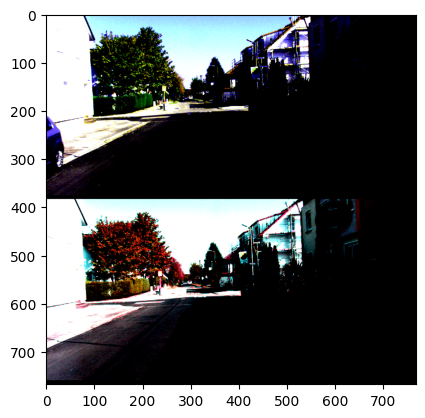

In [ ]:
img1 = batch[0][0]
img2 = batch[1][0]
print(img1.shape)
plt.imshow(torch.cat([img1, img2], dim=1).permute(1,2,0))

## 3. DispNet

[Paper](https://openaccess.thecvf.com/content_cvpr_2016/papers/Mayer_A_Large_Dataset_CVPR_2016_paper.pdf), [poster](https://lmb.informatik.uni-freiburg.de/Publications/2016/MIFDB16/poster-MIFDB16.pdf), [supplimentary materials](https://lmb.informatik.uni-freiburg.de/Publications/2016/MIFDB16/supplementary-MIFDB16.pdf), [project page](https://lmb.informatik.uni-freiburg.de/Publications/2016/MIFDB16/)

### 3.1 DispNet Simple

The simplest way to predict the disparity is just concat pair of images and feed it to unet-like architecture.

[[FlowNet paper]](https://arxiv.org/pdf/1504.06852.pdf)

<img src="https://miro.medium.com/max/2400/0*LPtmtLr-mugr8OtN.png" style="width:80%">
<img src="https://miro.medium.com/max/692/0*blFDiciN3KbPNeov.png" style="width:80%">

Network architecture in more details:

<img src="./dispnet.png" style="width:50%">

In [ ]:
class ConvBNRelu(torch.nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, *args, **kwargs)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class UpConvBNRelu(torch.nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__()
        self.conv = torch.nn.ConvTranspose2d(in_channels, out_channels, *args, **kwargs)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class DispNetSimple(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvBNRelu(6, 64, kernel_size=(7,7), stride=2, padding=(3,3))
        self.conv2 = ConvBNRelu(64, 128, kernel_size=(5,5), stride=2, padding=(2,2))
        self.conv3 = torch.nn.Sequential(
            ConvBNRelu(128, 256, kernel_size=(5,5), stride=2, padding=(2,2)),
            ConvBNRelu(256, 256, kernel_size=(3,3), stride=1, padding=(1,1)))
        self.conv4 = torch.nn.Sequential(
            ConvBNRelu(256, 512, kernel_size=(3,3), stride=2, padding=(1,1)),
            ConvBNRelu(512, 512, kernel_size=(3,3), stride=1, padding=(1,1)))
        self.conv5 = torch.nn.Sequential(
            ConvBNRelu(512, 512, kernel_size=(3,3), stride=2, padding=(1,1)),
            ConvBNRelu(512, 512, kernel_size=(3,3), stride=1, padding=(1,1)))
        self.conv6 = torch.nn.Sequential(
            ConvBNRelu(512, 1024, kernel_size=(3,3), stride=2, padding=(1,1)),
            ConvBNRelu(1024, 1024, kernel_size=(3,3), stride=1, padding=(1,1)))
        self.pred6 = torch.nn.Conv2d(1024, 1, kernel_size=3, stride=1, padding=(1,1))

        self.upconv5 = UpConvBNRelu(1024, 512, kernel_size=4, stride=2, padding=(1,1))
        self.iconv5 = ConvBNRelu(1025, 512, kernel_size=3, stride=1, padding=(1,1))
        self.pred5 = torch.nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=(1,1))

        self.upconv4 = UpConvBNRelu(512, 256, kernel_size=4, stride=2, padding=(1,1))
        self.iconv4 = ConvBNRelu(256+512+1, 256, kernel_size=3, stride=1, padding=(1,1))
        self.pred4 = torch.nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=(1,1))

        self.upconv3 = UpConvBNRelu(256, 128, kernel_size=4, stride=2, padding=(1,1))
        self.iconv3 = ConvBNRelu(128+256+1, 128, kernel_size=3, stride=1, padding=(1,1))
        self.pred3 = torch.nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=(1,1))

        self.upconv2 = UpConvBNRelu(128, 64, kernel_size=4, stride=2, padding=(1,1))
        self.iconv2 = ConvBNRelu(64+128+1, 64, kernel_size=3, stride=1, padding=(1,1))
        self.pred2 = torch.nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=(1,1))

        self.upconv1 = UpConvBNRelu(64, 32, kernel_size=4, stride=2, padding=(1,1))
        self.iconv1 = ConvBNRelu(32+64+1, 32, kernel_size=3, stride=1, padding=(1,1))
        self.pred1 = torch.nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=(1,1))

    def forward(self, left_img, right_img):
        x = torch.cat([left_img, right_img], dim=1)
        maps = []
        for layer in [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5, self.conv6]:
          x = layer(x)
          # print(x.shape)
          maps.append(x)

        predictions_per_scale = []
        predict6 = self.pred6(x)
        predictions_per_scale.append(predict6)
        maps.pop()

        decoder = [
            [self.upconv5, self.iconv5, self.pred5],
            [self.upconv4, self.iconv4, self.pred4],
            [self.upconv3, self.iconv3, self.pred3],
            [self.upconv2, self.iconv2, self.pred2],
            [self.upconv1, self.iconv1, self.pred1],
        ]


        for upconv, iconv, pred in decoder:
          # print(x.shape)
          x = upconv(x)
          x = iconv(torch.cat([x,
                              maps[-1],
                              F.interpolate(predictions_per_scale[-1], scale_factor=2, mode='bilinear')],
                              dim=1))
          predict = pred(x)
          maps.pop()
          predictions_per_scale.append(predict)

        return predictions_per_scale


In [ ]:
dispnet = DispNetSimple()
for sample in train_batch_gen:
    left, right, target, mask = sample
    res = dispnet(left, right)
    break

### 3.2 Loss

In [ ]:
def compute_loss(predicted, target, mask):
    losses = []
    target_masked = target[mask]
    for scale_pred in predicted:
        scale_pred = torch.nn.functional.interpolate(
            scale_pred, size=target.shape[-2:], mode='bilinear', align_corners=True)
        scale_pred = scale_pred[mask]
        losses.append(torch.nn.functional.huber_loss(scale_pred, target_masked))
    total_loss = sum(losses) / len(losses)
    return total_loss, losses

In [ ]:
compute_loss(res, target, mask)

(tensor(35.6428, grad_fn=<DivBackward0>),
 [tensor(35.4733, grad_fn=<HuberLossBackward0>),
  tensor(35.6564, grad_fn=<HuberLossBackward0>),
  tensor(35.6103, grad_fn=<HuberLossBackward0>),
  tensor(35.5779, grad_fn=<HuberLossBackward0>),
  tensor(35.4474, grad_fn=<HuberLossBackward0>),
  tensor(36.0912, grad_fn=<HuberLossBackward0>)])

### 3.3 Training

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

dispnet = DispNetSimple()
dispnet = dispnet.to(device)

opt = torch.optim.Adam(dispnet.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
def train_network(network, opt, num_epochs=20):
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = []
        val_loss = []
        train_scale_losses = []
        val_scale_losses = []

        network.train(True)

        for x_left, x_right, gt, valid_pixels_mask in tqdm.tqdm(train_batch_gen):
            opt.zero_grad()
            x_left = x_left.to(device)
            x_right = x_right.to(device)
            valid_pvalid_pixels_mask_mask = valid_pixels_mask.to(device)
            gt = gt.to(device)

            pred = network(x_left, x_right)

            loss, scale_losses = compute_loss(pred, gt, valid_pixels_mask)
            loss.backward()
            opt.step()

            train_loss.append(loss.cpu().data.numpy())
            train_scale_losses.append(np.array([elem.cpu().data.numpy() for elem in scale_losses]))

        network.train(False)
        with torch.no_grad():
            for x_left, x_right, gt, valid_pixels_mask in val_batch_gen:
                x_left = x_left.to(device)
                x_right = x_right.to(device)
                gt = gt.to(device)
                valid_pixels_mask = valid_pixels_mask.to(device)

                pred = network(x_left, x_right)

                loss, scale_losses = compute_loss(pred, gt, valid_pixels_mask)

                val_loss.append(loss.cpu().data.numpy())
                val_scale_losses.append(np.array([elem.cpu().data.numpy() for elem in scale_losses]))

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f} , \t component loss: {}".format(
            np.mean(train_loss), np.mean(np.stack(train_scale_losses), axis=0)))
        print("  validation loss: \t\t\t{:.2f} , \t\t componnet loss: {}".format(
            np.mean(val_loss), np.mean(np.stack(val_scale_losses), axis=0)))

In [ ]:
train_network(dispnet, opt, num_epochs=20)

100%|██████████| 39/39 [00:58<00:00,  1.50s/it]


Epoch 1 of 20 took 63.919s
  training loss (in-iteration): 	20.334206 , 	 component loss: [12.032093 13.219235 16.058908 22.25311  27.523647 30.918247]
  validation loss: 			23.96 , 		 componnet loss: [18.386889 27.494438 30.259806 25.316174 20.00082  22.29743 ]


100%|██████████| 39/39 [00:55<00:00,  1.41s/it]


Epoch 2 of 20 took 62.066s
  training loss (in-iteration): 	9.524112 , 	 component loss: [ 6.8352036  6.7105703  6.7763267  7.442118  10.335518  19.044933 ]
  validation loss: 			10.22 , 		 componnet loss: [ 8.7507    9.087152  8.850875  9.407953 12.004111 13.20264 ]


100%|██████████| 39/39 [00:57<00:00,  1.47s/it]


Epoch 3 of 20 took 62.872s
  training loss (in-iteration): 	7.218407 , 	 component loss: [6.7818007 6.4627085 6.5639105 6.744758  7.4140086 9.343248 ]
  validation loss: 			9.98 , 		 componnet loss: [10.39991   9.948742  9.900978  9.478333  9.927835 10.239667]


100%|██████████| 39/39 [00:55<00:00,  1.42s/it]


Epoch 4 of 20 took 60.486s
  training loss (in-iteration): 	6.650708 , 	 component loss: [6.7833524 6.346016  6.4291945 6.521019  6.7429905 7.08167  ]
  validation loss: 			8.99 , 		 componnet loss: [8.799454 8.999972 8.893224 8.710383 8.938731 9.623136]


100%|██████████| 39/39 [00:56<00:00,  1.45s/it]


Epoch 5 of 20 took 61.502s
  training loss (in-iteration): 	6.322211 , 	 component loss: [6.3259706 6.2362566 6.174641  6.2384377 6.3902097 6.5677514]
  validation loss: 			9.36 , 		 componnet loss: [ 8.755973 10.331402 10.309129  8.650627  8.983287  9.155815]


100%|██████████| 39/39 [00:55<00:00,  1.41s/it]


Epoch 6 of 20 took 60.681s
  training loss (in-iteration): 	6.179577 , 	 component loss: [6.0354395 6.1233892 6.0084896 6.131195  6.2784333 6.50052  ]
  validation loss: 			9.10 , 		 componnet loss: [ 7.9697876  8.321932   8.456554   9.446893  10.116018  10.27762  ]


100%|██████████| 39/39 [00:55<00:00,  1.42s/it]


Epoch 7 of 20 took 60.362s
  training loss (in-iteration): 	6.172478 , 	 component loss: [6.1462965 6.0492325 6.028684  6.12969   6.2400713 6.44089  ]
  validation loss: 			8.88 , 		 componnet loss: [8.630087  8.56767   8.5756235 9.040406  9.207947  9.283342 ]


100%|██████████| 39/39 [00:57<00:00,  1.46s/it]


Epoch 8 of 20 took 62.482s
  training loss (in-iteration): 	6.012050 , 	 component loss: [6.0325885 6.014435  5.913029  5.9463253 6.034807  6.1311183]
  validation loss: 			8.81 , 		 componnet loss: [8.549613 9.039441 8.891309 8.729093 8.732923 8.918254]


100%|██████████| 39/39 [00:54<00:00,  1.41s/it]


Epoch 9 of 20 took 60.004s
  training loss (in-iteration): 	6.127207 , 	 component loss: [6.251488  5.984548  5.95571   5.99109   6.1720705 6.408332 ]
  validation loss: 			10.38 , 		 componnet loss: [ 8.886615   9.36356    9.4704075 10.504126  11.726568  12.341729 ]


100%|██████████| 39/39 [00:54<00:00,  1.41s/it]


Epoch 10 of 20 took 59.930s
  training loss (in-iteration): 	5.789942 , 	 component loss: [5.8845267 5.7398615 5.6614676 5.705688  5.802732  5.9453745]
  validation loss: 			10.01 , 		 componnet loss: [ 9.798372   9.270664   9.542945   9.9601145 10.45389   11.037848 ]


100%|██████████| 39/39 [00:56<00:00,  1.45s/it]


Epoch 11 of 20 took 62.099s
  training loss (in-iteration): 	5.864240 , 	 component loss: [5.9310565 5.7695913 5.6886563 5.768447  5.924022  6.1036663]
  validation loss: 			8.25 , 		 componnet loss: [8.643387  8.107651  7.8636093 8.024756  8.419126  8.441998 ]


100%|██████████| 39/39 [00:54<00:00,  1.40s/it]


Epoch 12 of 20 took 59.468s
  training loss (in-iteration): 	5.954506 , 	 component loss: [6.058058  5.9149523 5.8312745 5.88209   5.9670396 6.0736203]
  validation loss: 			8.90 , 		 componnet loss: [9.291146  8.716551  8.518311  8.708301  9.0393715 9.144687 ]


100%|██████████| 39/39 [00:55<00:00,  1.43s/it]


Epoch 13 of 20 took 60.498s
  training loss (in-iteration): 	5.496308 , 	 component loss: [5.577123  5.400322  5.3866844 5.3992615 5.5332217 5.6812363]
  validation loss: 			8.21 , 		 componnet loss: [8.714866  8.029752  7.9619446 7.953346  8.210997  8.382636 ]


100%|██████████| 39/39 [00:57<00:00,  1.48s/it]


Epoch 14 of 20 took 63.144s
  training loss (in-iteration): 	5.339439 , 	 component loss: [5.3968387 5.230581  5.2600965 5.289984  5.359568  5.4995675]
  validation loss: 			8.14 , 		 componnet loss: [7.9869018 7.8224573 7.803466  7.840963  8.386656  8.981796 ]


100%|██████████| 39/39 [00:55<00:00,  1.41s/it]


Epoch 15 of 20 took 60.055s
  training loss (in-iteration): 	5.270130 , 	 component loss: [5.3050685 5.1910644 5.1511903 5.206998  5.3247795 5.4416723]
  validation loss: 			8.75 , 		 componnet loss: [9.366959  9.0280485 8.281074  8.624357  8.524309  8.672206 ]


100%|██████████| 39/39 [00:54<00:00,  1.41s/it]


Epoch 16 of 20 took 59.771s
  training loss (in-iteration): 	5.745197 , 	 component loss: [5.8649473 5.848564  5.6081347 5.598437  5.713413  5.837683 ]
  validation loss: 			8.39 , 		 componnet loss: [ 7.484093  7.704105  7.919154  8.023389  9.072167 10.114945]


100%|██████████| 39/39 [00:56<00:00,  1.44s/it]


Epoch 17 of 20 took 61.531s
  training loss (in-iteration): 	5.255792 , 	 component loss: [5.268438  5.196573  5.1319427 5.1976395 5.3018265 5.438331 ]
  validation loss: 			7.74 , 		 componnet loss: [7.4503684 7.5063944 7.593544  7.5765414 8.004971  8.293355 ]


100%|██████████| 39/39 [00:54<00:00,  1.40s/it]


Epoch 18 of 20 took 59.440s
  training loss (in-iteration): 	5.659309 , 	 component loss: [5.773908  5.57005   5.5316434 5.5973496 5.7002025 5.7827067]
  validation loss: 			9.03 , 		 componnet loss: [10.166282  8.475017  8.374819  8.576819  9.237758  9.337   ]


100%|██████████| 39/39 [00:55<00:00,  1.41s/it]


Epoch 19 of 20 took 60.072s
  training loss (in-iteration): 	5.633466 , 	 component loss: [5.639264  5.5426564 5.525444  5.5738015 5.7144914 5.805138 ]
  validation loss: 			7.57 , 		 componnet loss: [7.3045177 7.3847117 7.101627  7.460687  8.064433  8.104311 ]


100%|██████████| 39/39 [00:56<00:00,  1.45s/it]


Epoch 20 of 20 took 61.976s
  training loss (in-iteration): 	5.222282 , 	 component loss: [5.20104   5.1335793 5.1054068 5.1742053 5.3081937 5.4112744]
  validation loss: 			12.42 , 		 componnet loss: [13.565596 11.326189 12.022026 11.995917 13.004272 12.578709]


In [ ]:
def visualize_result(network, img_index):
    network.train(False)
    for i, (x_left, x_right, target, mask) in enumerate(val_batch_gen):
        if i != img_index:
            continue
        pred = network(x_left.to(device), x_right.to(device))
        pred = pred[-1].cpu()
        break

    plt.figure(figsize=(20, 10))
    plt.subplot(3,1,1)
    plt.title('left image')
    plt.imshow(val_loader.left_images[img_index])
    plt.xticks([]), plt.yticks([])
    plt.subplot(3,1,2)
    plt.title('gt')
    plt.imshow(val_loader.targets[img_index])
    plt.xticks([]), plt.yticks([])
    plt.subplot(3,1,3)
    plt.title('pred')
    plt.imshow(pred.data.numpy()[0,0])
    plt.xticks([]), plt.yticks([])

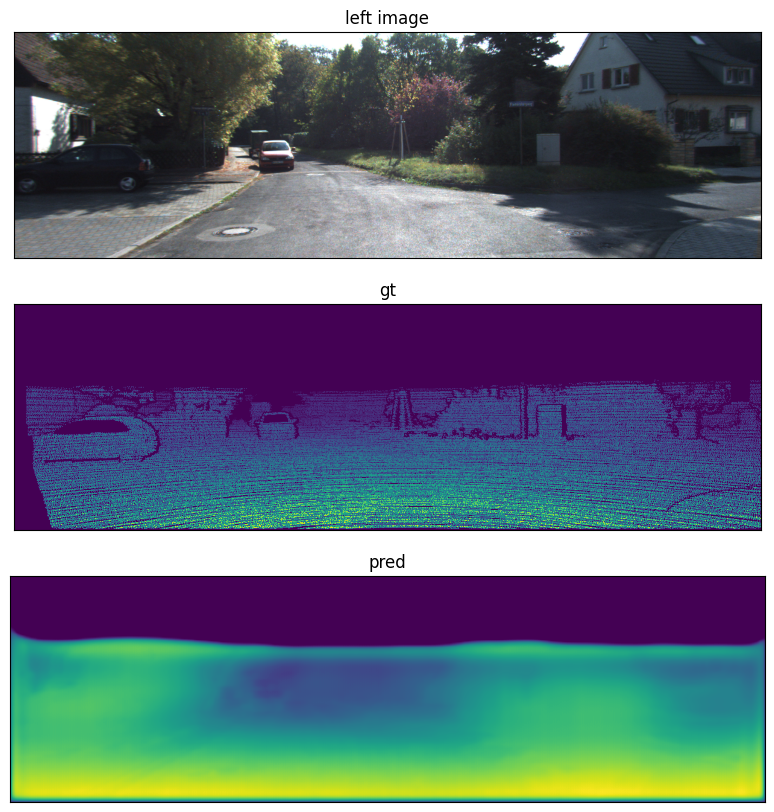

In [ ]:
visualize_result(dispnet, img_index=5)